<a href="https://colab.research.google.com/github/JIvanReyesH/EDs-ANN/blob/main/ANN_ODEs_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$$
\frac{d\psi}{dx} + \left(x + \frac{1 + 3x^{2}}{1 + x + x^{3}} \right)\psi = x^{3} + 2x + x^{2}\left(\frac{1 + 3x^{2}}{1 + x + x^{3}}\right)
$$
Con CI: $\psi(0) = 1$ \
$x \in [0,2]$

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt 
import numpy as np

In [ ]:
def RK3(f, U_0, dt, T):
    N_t = int(round(T/dt))
    t = np.linspace(0, N_t*dt, N_t + 1)
    u = np.zeros(N_t +1)
    # Initial condition
    u[0] = U_0
    # RK3
    for n in range(N_t):
        k1 = f(u[n],t[n])
        k2 = f(u[n] + 0.5*dt, t[n]+ 0.5*dt)
        k3 = f(u[n] - dt*k1 + 2*dt*k2, t[n] + dt)
        u[n+1] = u[n] + (1./6.)*dt*(k1 + 4*k2 + k3)
    return u, t

def RK4(f, X_0, dt, T):
    N_t = int(round(T/dt))
    u = np.zeros((N_t+1,len(X_0))) 
    t = np.linspace(0, N_t*dt, len(u))
    # Initial conditions
    for j in range(len(X_0)):
        u[j,0] = X_0[j]
    # RK4
    for n in range(N_t):
        u1 = f(u[n] + 0.5*dt* f(u[n], t[n]), t[n] + 0.5*dt)
        u2 = f(u[n] + 0.5*dt*u1, t[n] + 0.5*dt)
        u3 = f(u[n] + dt*u2, t[n] + dt)
        u[n+1] = u[n] + (1/6)*dt*( f(u[n], t[n]) + 2*u1 + 2*u2 + u3)
    return u, t

In [ ]:
def A(x):
    return x + (1. + 3.*x**2) / (1. + x + x**3)

def B(x):
    return x**3 + 2.*x + x**2 * ((1. + 3.*x**2) / (1. + x + x**3))

def f(psi, x):
    return B(x) - psi * A(x)

In [ ]:
def psy_analytic(x):
    return (np.exp((-x**2)/2.))/(1. + x + x**3) + x**2

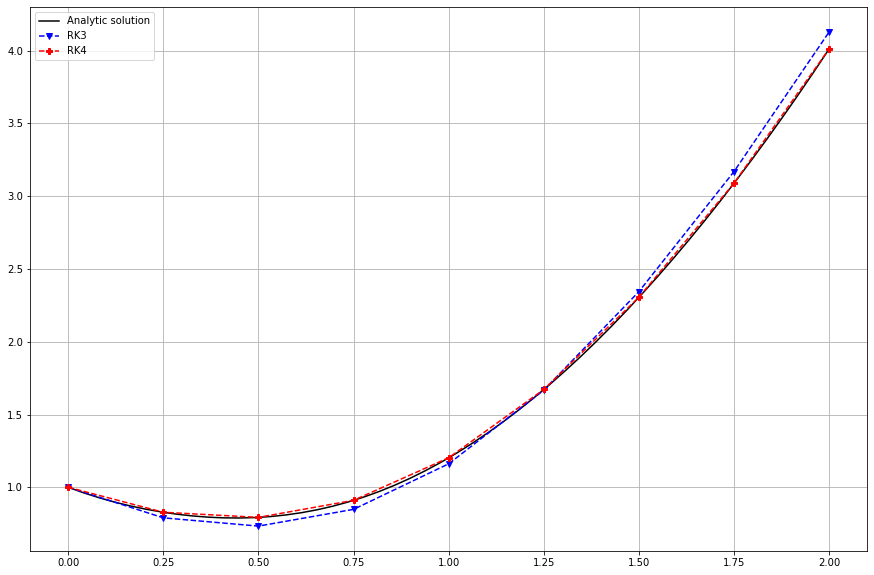

In [ ]:
# Método RK 4
CI = 1,
sol_RK4, _ = RK4(f, CI, 0.25, 2)

# Método RK 3
sol_RK3, _ = RK3(f, 1, 0.25, 2)

x = np.linspace(0, 2, 9)

x_dom = np.linspace(0, 2)
fig = plt.subplots(figsize=(15, 10))
plt.plot(x_dom, psy_analytic(x_dom), color='black', label='Analytic solution')
plt.plot(x, sol_RK3, color='blue', marker='v', linestyle='dashed', label='RK3')
plt.plot(x, sol_RK4, color='red', marker='P', linestyle='dashed', label='RK4')
plt.legend()
plt.grid(True)
plt.show()

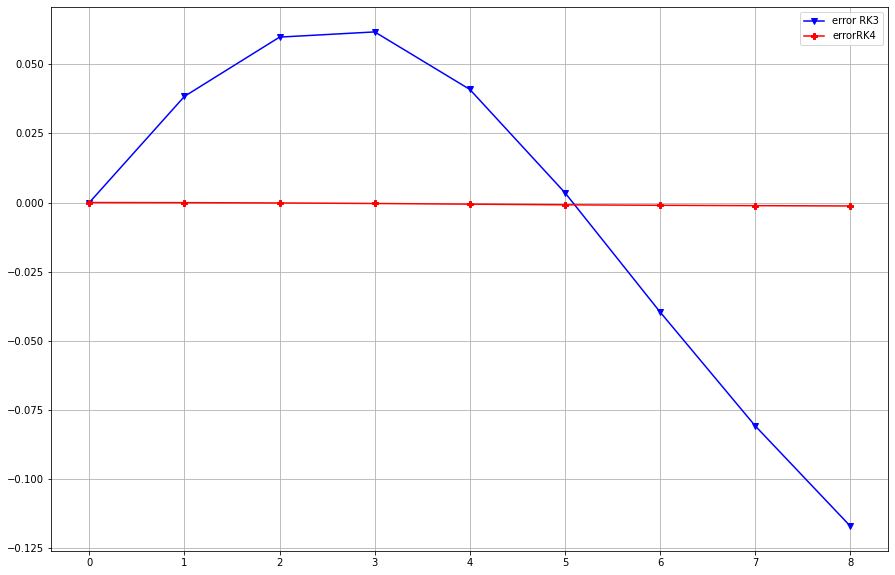

In [ ]:
err_RK3 = psy_analytic(x) - sol_RK3
err_RK4 = psy_analytic(x) - np.squeeze(sol_RK4)

fig = plt.subplots(figsize=(15, 10))
plt.plot(err_RK3, color='blue', marker='v', label='error RK3')
plt.plot(err_RK4, color='red', marker='P', label='errorRK4')

plt.legend()
plt.grid(True)
plt.show()

### Usando ANN

In [ ]:
class NN_ODE(nn.Module): # Arquitectura de Pepe
    def __init__(self):
        super(NN_ODE, self).__init__()
        self.fc1 = nn.Linear(1,11)
        self.fc2 = nn.Linear(11,43)
        self.fc3 = nn.Linear(43,1)
        self.fc4 = nn.LogSoftmax(dim = 1)

    def forward(self, X):
        out = torch.sigmoid(self.fc1(X))
        out = self.fc4(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
def loss(model, X, X_0):
    #Calcular derivadas
    psy = model(X)
    dpsy_dx = autograd.grad(psy.sum(),X, create_graph=True)[0]

    #ODE
    eq = dpsy_dx - f(psy, X)

    #Condiciones iniciales
    psy_0 = model(X_0)
    dpsy_0_dx = autograd.grad(psy_0.sum(), X_0, create_graph=True)[0]
    
    c1 = psy_0 - torch.tensor([[1.]])
 
    return (eq**2).mean() + (c1**2).mean()

In [ ]:
model = NN_ODE()
optimizer = torch.optim.AdamW(model.parameters())


X_t_1 = torch.linspace(0,2, steps=9,requires_grad=True).reshape(-1,1)
X_0 = torch.tensor([[0.]], requires_grad=True)

epochs = 5001

for i in range(epochs):
    cost = loss(model, X_t_1, X_0)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if (i)%1000 == 0:
        print(f"epoch:{i}, loss:{cost:.15f}")

epoch:0, loss:22.686805725097656
epoch:1000, loss:2.289806365966797
epoch:2000, loss:0.039316270500422
epoch:3000, loss:0.009395657107234
epoch:4000, loss:0.001379317371175
epoch:5000, loss:0.000963610946201


In [ ]:
model.eval()

NN_ODE(
  (fc1): Linear(in_features=1, out_features=11, bias=True)
  (fc2): Linear(in_features=11, out_features=43, bias=True)
  (fc3): Linear(in_features=43, out_features=1, bias=True)
  (fc4): LogSoftmax()
)

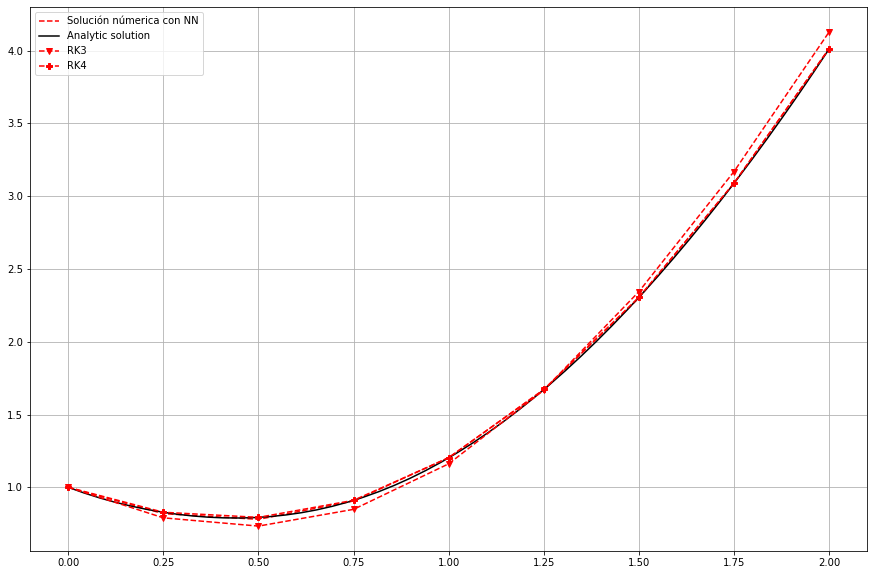

In [ ]:
X2 = torch.linspace(0,2, steps=9,requires_grad=False).reshape(-1,1)

fig = plt.subplots(figsize=(15, 10))
plt.plot(X2.cpu().numpy(), model(X2).cpu().detach().numpy() , "r--", label = "Solución númerica con NN")
plt.plot(x_dom, psy_analytic(x_dom), color='black', label='Analytic solution')
plt.plot(x, sol_RK3, color='red', marker='v', linestyle='dashed', label='RK3')
plt.plot(x, sol_RK4, color='red', marker='P', linestyle='dashed', label='RK4')
plt.legend()
plt.grid(True)
plt.show()

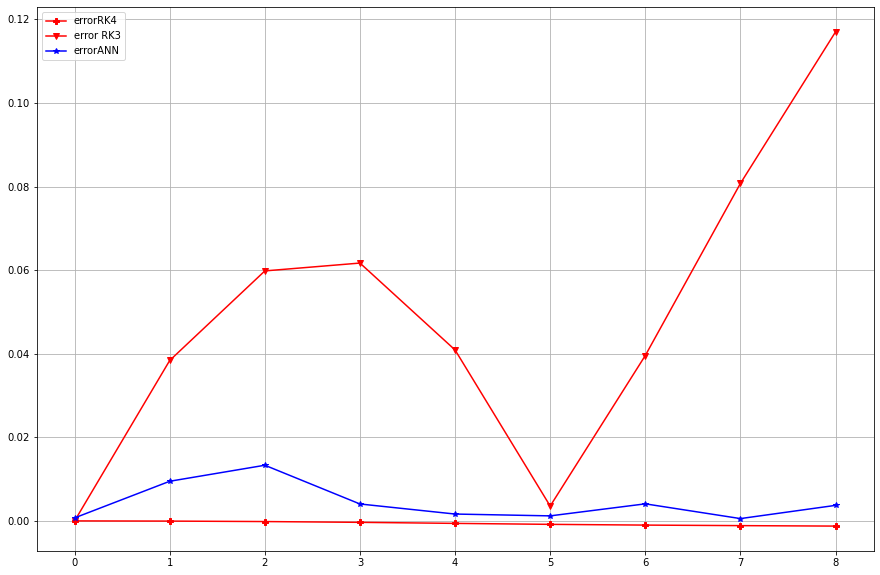

In [ ]:
err_RK4 = psy_analytic(x) - np.squeeze(sol_RK4)
err_RK3 = psy_analytic(x) - sol_RK3
err_ANN = psy_analytic(x) - np.squeeze(model(X2).cpu().detach().numpy())

fig = plt.subplots(figsize=(15, 10))
plt.plot(err_RK4, color='red', marker='P', label='errorRK4')
plt.plot(abs(err_RK3), color='red', marker='v', label='error RK3')
plt.plot(abs(err_ANN), color='blue', marker='*', label='errorANN')

plt.legend()
plt.grid(True)
plt.show()